In [107]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
from exact import solve
from policies import FixedPlanPolicy
from mouselab_policy import MouselabPolicy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=3, sigma=6, quantization=6, cost=1.00, seed=None, branching=[2,2], **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            d = Normal(mu, sigma).to_discrete(quantization)
            return Categorical(map(round, d.vals), d.probs)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

In [128]:
env = make_env(0, 6, branching=(2,2,1), quantization=3, term_belief=True, ground_truth=False)
Q, V, pi, info = solve(env)
%prun V(env.init)

# Simulations

In [84]:
def simulate(mu, sigma, branching=(2,2)):
    envs = [make_env(mu, sigma, branching=branching) for _ in range(300)]
    env = envs[0]
    Q, V, pi, info = solve(env)
    return pd.DataFrame({
        'optimal': get_util(SoftmaxPolicy(Q), envs, return_mean=0),
        'random': get_util(MouselabPolicy({'term_reward': 0}), envs, return_mean=0),
        'full': get_util(FixedPlanPolicy(range(1, env.term_action+1)), envs, return_mean=0),
    })

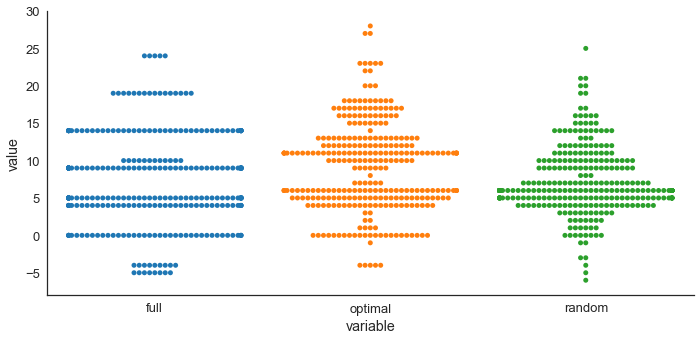

In [96]:
sns.factorplot('variable', 'value', data=pd.melt(df), kind='swarm',
               size=5, aspect=2)

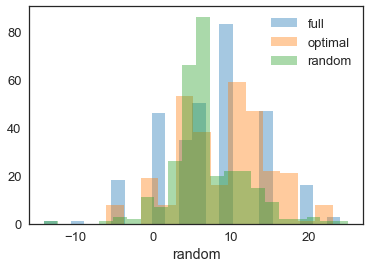

In [87]:
for k, v in df.items():
    sns.distplot(v, label=k, kde=0)
plt.legend()

In [114]:
def simulate(mu, sigma, branching=(2,2)):
    envs = [make_env(mu, sigma, branching=branching) for _ in range(300)]
    env = envs[0]
    Q, V, pi, info = solve(env)
    return {
        'branching': branching,
        'sigma': sigma,
        'optimal': V(env.init),
        'random': get_util(MouselabPolicy({'term_reward': 0}), envs),
        'full': get_util(FixedPlanPolicy(range(1, env.term_action+1)), envs),
    }

df = pd.DataFrame(simulate(0, sigma)
                  for sigma in range(4, 15)).set_index('sigma')
# df = pd.DataFrame(simulate(3, 7, b) for b in solutions).set_index('branching')

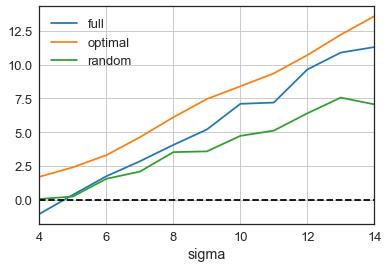

In [115]:
df.plot()
plt.axhline(0, c='k', ls='--')
plt.grid()
# plt.ylim(-4, 10)

In [59]:
from evaluation import get_util
from policies import SoftmaxPolicy

def util(mu, sigma, branching):
    envs = envs = [make_env(mu, sigma, branching=branching) for _ in range(300)]
    pol = SoftmaxPolicy(solutions[branching][0])
    return get_util(pol, envs, return_mean=0)
    
utils = {b: util(0, 4, b) for b in solutions}

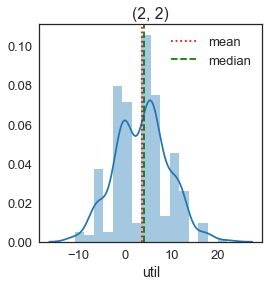

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(4,4), sharex='all', squeeze=0)
axes = iter(axes.flat)
for b, util in utils.items():
    plt.sca(next(axes))
    sns.distplot(util)
    plt.axvline(util.mean(), c='r', ls=':', label='mean')
    plt.axvline(util.median(), c='g', ls='--', label='median')
    plt.title(b)
plt.legend()

In [ ]:
sns.distplot()

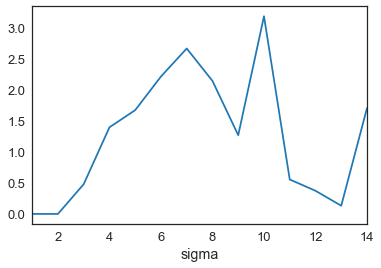

In [60]:
alt = np.max([df.full, df.random, np.zeros_like(df.full)], axis=0)
(df.optimal - alt).plot()

# Save environments to JSON files

In [95]:
import json

def env_data(env):
    return {
        'trial_id': hash(env) % 100000000,
        'stateRewards': list(map(round,env.ground_truth)),
    }

cost = 1.00
environments = ["binary_tree_constant_high","binary_tree_constant_low","binary_tree_increasing"]
nr_environments = 100

for env_type in environments:
    envs = make_envs(cost,nr_environments,None,env_type)

    with open('data/experiment_trials/binary_trees_'+env_type+'.json','w+') as f:
        json.dump(list(map(env_data, envs)), f)

# Hashing

In [102]:
from toolz import compose
h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

In [15]:
from contexttimer import Timer
def test_hash(env, hash_state):
    Q, V, pi, info = solve(env, hash_state=hash_state)
    with Timer() as t:
        info['value'] = V(env.init)
        info['time'] = round(t.elapsed, 3)
    print(info)
    return info

In [16]:
def hash_22(state):
    s = [hash(x) + 100000 for x in state]
    return (
        h(s[1] +
          h(s[2]) + 
          h(s[3])) +
        h(s[4] +
          h(s[5]) + 
          h(s[6]))
    )
env = make_env(quantization=2, branching=[2, 2])
test_hash(env, None)
test_hash(env, hash_22);

{'q': 513, 'v': 172, 'value': 17.375, 'time': 0.027}
{'q': 513, 'v': 172, 'value': 17.375, 'time': 0.012}


In [17]:
def hash_221(state):
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] +
        h(s[2] + s[3]) +
        h(s[4] + s[5])
      ) +
      h(s[6] + 
        h(s[7] + s[8]) +
        h(s[9] + s[10])
      )
    )
env = make_env(quantization=2, branching=[2,2,1])
test_hash(env, None)
test_hash(env, hash_221);

{'q': 39780, 'v': 9181, 'value': 22.8515625, 'time': 2.218}
{'q': 8736, 'v': 2017, 'value': 22.8515625, 'time': 0.207}


{'q': 8736, 'time': 0.207, 'v': 2017, 'value': 22.8515625}

In [ ]:
def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

In [101]:
def hash_x12(state):
    """Works for x12 for x in [1,2,3,4]"""
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

env = make_env(0, 6, quantization=4, branching=[2,1,2])
test_hash(env, hash_412);

{'q': 45612, 'v': 16291, 'value': 3.9888561429777862, 'time': 2.563}


In [58]:
def test(branch, quant):
    env = make_env(0, 6, quantization=quant, branching=[branch,1,2])
    return {'branch': branch, 'quant': quant,
            **test_hash(env, hash_412)}

df = pd.DataFrame(test(b, q)
                  for b in (2,3)
                  for q in (2,3,4,5))

{'q': 2442, 'v': 667, 'value': 12.28125, 'time': 0.101}
{'q': 12740, 'v': 4096, 'value': 4.0369598263856812, 'time': 0.613}
{'q': 45612, 'v': 16291, 'value': 3.9888561429777862, 'time': 2.666}
{'q': 129402, 'v': 49771, 'value': 3.8640320863321427, 'time': 8.517}


In [91]:
# from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

m = ols('logtime ~ branch * quant', data=df1).fit()
m.predict({'branch': [3, 4], 'quant': [6, 4]})
m = ols('logtime ~ branch * C(quant)', data=df1).fit()
np.exp(m.predict({'branch': [3, 4], 'quant': 4})) / 60

0    10.413982
1    10.274076
dtype: float64

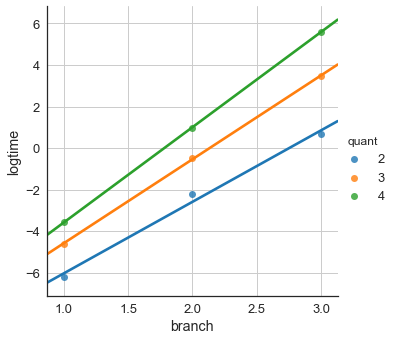

In [79]:
sns.lmplot('branch', 'logtime', data=df1, hue='quant', ci=0)
plt.grid()

In [106]:
df1.set_index(['branch', 'quant']).time

branch  quant
1       2          0.002
        3          0.010
        4          0.028
2       2          0.109
        3          0.614
        4          2.691
3       2          1.952
        3         32.241
        4        268.882
Name: time, dtype: float64

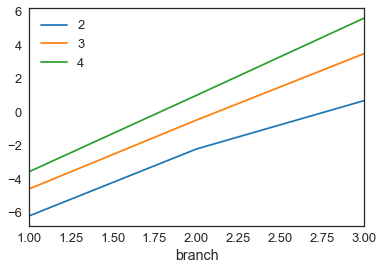

In [54]:

df.set_index('branch').groupby('quant').logtime.plot()
# df.set_index('quant').groupby('branch').time.plot()
plt.legend()


In [44]:
df['branch'], df['quant'] = zip(*((b, q) for b in (1,2,3) for q in (2,3,4)))

# Other

In [98]:
solutions = {}
from contexttimer import Timer
branchings = [
    (2, 2),
#     (2, 1, 1),
#     (3, 1, 1),
#     (2, 2, 1),
#     (4, 1, 1),
]
for b in branchings:
    print(b)
    env = make_env(3, 7, branching=b)
    with Timer(output=print):
        Q, V, pi, info = solve(env)
        V(env.init)
        solutions[b] = Q, V, pi, info
    

OrderedDict([('is_term', -5.7794558064077215),
             ('term_reward', 1),
             ('voi_myopic', 0.40188963457315541),
             ('vpi_action', 0.19622073085368916),
             ('vpi_full', 0.40188963457315541),
             ('quality_ev', 0),
             ('quality_std', 0),
             ('depth', 0)])